In [12]:
from datetime import datetime, timedelta
import yfinance as yf
start_date = "2023-08-03"
end_date = datetime.now().strftime('%Y-%m-%d')

tsla_data = yf.download("JPM", start=start_date, end=end_date, interval="1d")

finance_csv_file = "financial_anomaly_data.csv"
tsla_data.to_csv(finance_csv_file)
print(f"financial data saved to {finance_csv_file}")

[*********************100%***********************]  1 of 1 completed

financial data saved to financial_anomaly_data.csv


In [13]:
import pandas as pd

# Load raw CSV without setting headers
df_raw = pd.read_csv("financial_anomaly_data.csv", header=None)

# Extract column names from row 0
column_names = df_raw.iloc[0].tolist()
column_names[0] = "Date"

# Extract the actual financial data from row 3 onwards
df_financial = df_raw.iloc[3:].copy()

# Assign proper column names
df_financial.columns = column_names

# Convert "Date" column to datetime
df_financial["Date"] = pd.to_datetime(df_financial["Date"], errors="coerce")

# Ensure numerical columns are properly converted
num_cols = df_financial.columns[1:]  # Exclude "Date"
df_financial[num_cols] = df_financial[num_cols].apply(pd.to_numeric, errors="coerce")

# Sort by date
df_financial = df_financial.sort_values("Date").reset_index(drop=True)

# Save the cleaned financial data
df_financial.to_csv("processed_financial_data.csv", index=False)

print("Financial data")
print(df_financial.head())

Financial data
        Date       Close        High         Low        Open   Volume
0 2023-08-03  150.806183  151.355964  148.877098  149.504045  6084000
1 2023-08-04  150.487869  152.204753  150.179209  150.854385  6206600
2 2023-08-07  151.201614  152.108286  151.047299  151.047299  7251800
3 2023-08-08  150.352829  150.449274  147.179477  148.848146  8623400
4 2023-08-09  148.336914  150.005582  148.028268  149.812677  6277800


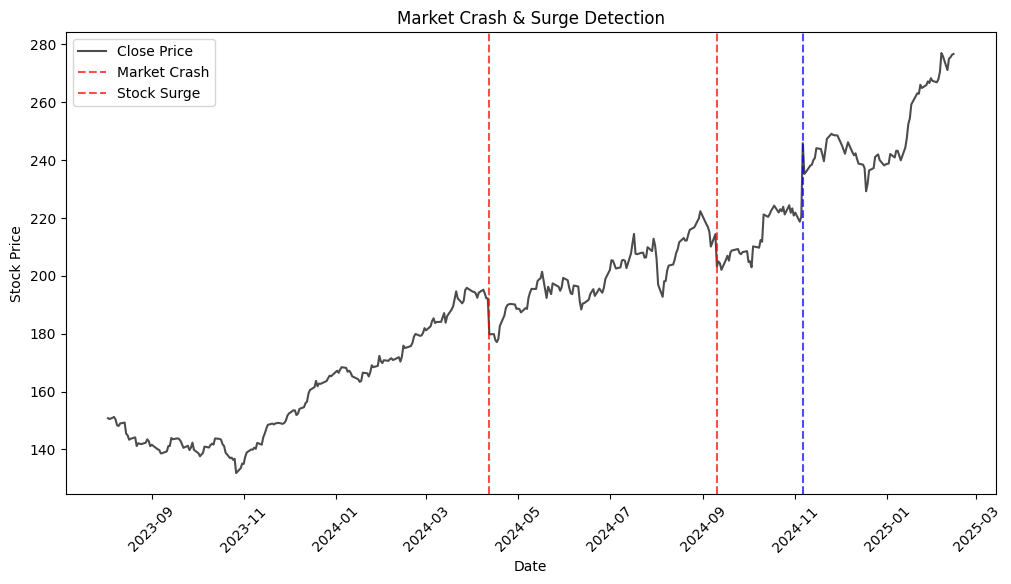

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load processed financial data
df = pd.read_csv("processed_financial_data.csv")

# Convert "Date" to datetime
df["Date"] = pd.to_datetime(df["Date"])

# Compute Daily Returns
df["Returns"] = df["Close"].pct_change() * 100  # Convert to percentage

# Compute Rolling Volume Mean & Standard Deviation
window = 20
df["RollingVolume"] = df["Volume"].rolling(window=window).mean()
df["RollingStdVolume"] = df["Volume"].rolling(window=window).std()

# Compute Volatility (Rolling Standard Deviation of Returns)
df["Volatility"] = df["Returns"].rolling(window=window).std()

# Detect Anomalies
df["Anomaly"] = 0  # Default: No anomaly

# Detect Market Crashes (Large Drops)
df.loc[(df["Returns"] < -5), "Anomaly"] = -1  # Crash detected

# Detect Rapid Price Surges (Stock Skyrocketing)
df.loc[(df["Returns"] > 5), "Anomaly"] = 1  # Surge detected

# Detect High Volume Spikes
df["HighVolume"] = df["Volume"] > (df["RollingVolume"] + df["RollingStdVolume"] * 2)

# Filter only significant anomalies (confirmed by high volume)
df.loc[(df["Anomaly"] != 0) & (df["HighVolume"] == True), "Confirmed_Anomaly"] = df["Anomaly"]

# Save detected anomalies
df.to_csv("market_crashes_and_surges.csv", index=False)

# Plot Market Crashes & Surges
plt.figure(figsize=(12,6))
plt.plot(df["Date"], df["Close"], label="Close Price", color="black", alpha=0.7)

# Add vertical lines for Market Crashes
for crash_date in df[df["Anomaly"] == -1]["Date"]:
    plt.axvline(x=crash_date, color="red", linestyle="--", alpha=0.7)

# Add vertical lines for Stock Surges
for surge_date in df[df["Anomaly"] == 1]["Date"]:
    plt.axvline(x=surge_date, color="blue", linestyle="--", alpha=0.7)

plt.legend(["Close Price", "Market Crash", "Stock Surge"])
plt.title("Market Crash & Surge Detection")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.xticks(rotation=45)
plt.show()



In [ ]:
import requests
import pandas as pd
from datetime import datetime, timedelta

# API Credentials
NEWSAPI_APP_KEY = ""  # Add your API Key
NEWSAPI_APP_ID = ""
HEADERS = {
    'X-AYLIEN-NewsAPI-Application-ID': NEWSAPI_APP_ID,
    'X-AYLIEN-NewsAPI-Application-Key': NEWSAPI_APP_KEY
}

# Load detected anomalies
# Load detected anomalies
df_anomalies = pd.read_csv("market_crashes_and_surges.csv")

# Convert "Date" to datetime
df_anomalies["Date"] = pd.to_datetime(df_anomalies["Date"])

# Set the stock name and ticker dynamically
STOCK_NAME = "JPMorgan"
STOCK_TICKER = "JPM"

# Store news results
news_results = []

for _, row in df_anomalies.iterrows():
    anomaly_date = row["Date"]
    anomaly_type = row["Anomaly"]

    # Define search window (±2 days)
    start_date = (anomaly_date - timedelta(days=2)).strftime('%Y-%m-%dT00:00:00.000Z')
    end_date = (anomaly_date + timedelta(days=2)).strftime('%Y-%m-%dT23:59:59.999Z')

    # Determine situation type
    situation = "Stock Surge" if anomaly_type == 1 else "Market Crash" if anomaly_type == -1 else None
    if situation is None:
        continue  # Skip if no anomaly detected

    # **Build Query for Aylien API**
    entities_query = '{{surface_forms:("' + STOCK_NAME + '" OR "' + STOCK_TICKER + '") AND overall_prominence:>=0.65}}'

    # API request parameters
    params = {
        "published_at.start": start_date,
        "published_at.end": end_date,
        "language": "en",
        "entities": entities_query,
        "source.rankings.alexa.rank.min": "1",
        "source.rankings.alexa.rank.max": 10,
        "per_page": 5,  # Get top 5 relevant articles
    }

    # Call Aylien News API
    response = requests.get("https://api.aylien.com/v6/news/stories", params=params, headers=HEADERS)
    
    if response.status_code == 200:
        result = response.json()
        articles = result.get("stories", [])

        # Print situation heading
        print("\n" + "="*40)
        print(f"News Articles for {situation} on {anomaly_date.strftime('%Y-%m-%d')}")
        print("="*40)

        # Add separator for CSV readability
        news_results.append({"Anomaly Date": "", "Stock": "", "Type": "", "Title": "", "Body": "", "Published Date": "", "Source": "", "URL": ""})
        news_results.append({"Anomaly Date": f"==== {situation}: {anomaly_date.strftime('%Y-%m-%d')} ====", "Stock": "", "Type": "", "Title": "", "Body": "", "Published Date": "", "Source": "", "URL": ""})
        
        for article in articles:
            news_entry = {
                "Anomaly Date": anomaly_date.strftime('%Y-%m-%d'),
                "Stock": STOCK_NAME,
                "Type": situation,
                "Title": article["title"],
                "Body": article.get("body", "No article body available"),  # Store article body
                "Published Date": article["published_at"][:10],
                "Source": article["source"]["name"],
                "URL": article["links"]["permalink"]
            }
            news_results.append(news_entry)

            # Print each news entry
            print(f"- {article['title']} ({article['published_at'][:10]})")
            print(f"  Source: {article['source']['name']}")
            print(f"  URL: {article['links']['permalink']}\n")
            print(f"  Body: {article.get('body', 'No article body available')[:200]}...\n")  # Print first 200 chars

    else:
        print(f"Error fetching news for {anomaly_date}: {response.status_code} - {response.text}")

# Convert news results to DataFrame
df_news = pd.DataFrame(news_results)

# Save news articles related to anomalies
df_news.to_csv("anomaly_news_results.csv", index=False)

print("\nNews results saved to anomaly_news_results.csv")


News Articles for Market Crash on 2024-04-12
- The Q1 Earnings Season Kicks off Positively (2024-04-13)
  Source: Yahoo UK
  URL: https://uk.finance.yahoo.com/news/q1-earnings-season-kicks-off-202800895.html

  Body: In this article:  ^GSPC  The market isn't particularly impressed with what it saw in the quarterly releases from JPMorgan JPM, Citigroup C, and even Wells Fargo WFC.
Part of the issue appears to be un...

- JPMorgan earnings call struck 'cautious' tone on high rates - Yahoo Finance (2024-04-13)
  Source: Google News
  URL: https://news.google.com/rss/articles/CBMiVWh0dHBzOi8vZmluYW5jZS55YWhvby5jb20vdmlkZW8vanBtb3JnYW4tZWFybmluZ3MtY2FsbC1zdHJ1Y2stY2F1dGlvdXMtMTU1MTU0NDY1Lmh0bWzSAQA?oc=5

  Body: <ol><li><a href="https://news.google.com/rss/articles/CBMiVWh0dHBzOi8vZmluYW5jZS55YWhvby5jb20vdmlkZW8vanBtb3JnYW4tZWFybmluZ3MtY2FsbC1zdHJ1Y2stY2F1dGlvdXMtMTU1MTU0NDY1Lmh0bWzSAQA?oc=5" target="_blank">...

- Jamie Dimon warns that markets are 'too happy' and failing to price in a po

In [ ]:
!pip install sumy

In [16]:
import spacy
import re
import pandas as pd
from sumy.parsers.plaintext import PlaintextParser
from sumy.summarizers.text_rank import TextRankSummarizer

# Load SpaCy English model
nlp = spacy.load("en_core_web_sm")

class SpacyTokenizer:
    def __init__(self, language="english"):
        self.language = language

    def to_sentences(self, text):
        """Split text into sentences using SpaCy"""
        doc = nlp(text)
        return [sent.text for sent in doc.sents]

    def to_words(self, text):
        """Tokenize text into words using SpaCy"""
        doc = nlp(text)
        return [token.text for token in doc if not token.is_space]

# Summarization function
def summarize_article(text, num_sentences=2):
    """ Extractive summarization using TextRank with SpaCy tokenizer """
    if pd.isna(text) or text.strip() == "":
        return "No content available for summarization."

    parser = PlaintextParser.from_string(text, SpacyTokenizer()) 
    summarizer = TextRankSummarizer()
    summary = summarizer(parser.document, num_sentences)
    return " ".join([str(sentence) for sentence in summary])

# Load news data
df_news = pd.read_csv("anomaly_news_results.csv", dtype=str)

# Process CSV row by row to identify event headers and summarize articles
current_event = None

for _, row in df_news.iterrows():
    # Check if the row is a section header
    if re.match(r"==== (Market Crash|Stock Surge): \d{4}-\d{2}-\d{2} ====", str(row.iloc[0])):
        current_event = row.iloc[0]  # Store the event header
        print("\n" + "="*60)
        print(f"{current_event}")  # Print event heading
        print("="*60)
        continue  # Move to next row

    # If it's a normal news row, summarize it
    if current_event:
        title = row["Title"]
        body = row.get("Body", title) 
        url = row["URL"]
        summary = summarize_article(body)  

        print(f"\n **{title}**")
        print(f"Summary: {summary}")
        print(f"Source: {url}")
        print("-" * 40)




==== Market Crash: 2024-04-12 ====

 **The Q1 Earnings Season Kicks off Positively**
Summary: The Earnings Big Picture Looking at Q1 as a whole, total S&P 500 earnings are expected to be up +2.9% from the same period last year on +3.8% higher revenues, which would follow the +6.8% earnings growth on +4.0% revenue gains in the preceding period. For 2024 Q1, net margins are expected to be below the year-earlier level for 9 of the 16 Zacks sectors, with the biggest declines in the Energy, Basic Materials, Autos, and Medical sectors.
Source: https://uk.finance.yahoo.com/news/q1-earnings-season-kicks-off-202800895.html
----------------------------------------

 **JPMorgan earnings call struck 'cautious' tone on high rates - Yahoo Finance**
Summary: <ol><li><a href="https://news.google.com/rss/articles/CBMiVWh0dHBzOi8vZmluYW5jZS55YWhvby5jb20vdmlkZW8vanBtb3JnYW4tZWFybmluZ3MtY2FsbC1zdHJ1Y2stY2F1dGlvdXMtMTU1MTU0NDY1Lmh0bWzSAQA?oc=5" target="_blank">JPMorgan earnings call struck 'cautious' tone